# Исследование данных о продаже игр

В нашем распоряжении исторические данные о продажах игр, оценки пользователей и экспертов, жанры и платформы (например, Xbox или PlayStation). Необходимо выявить определяющие успешность игры закономерности. Это позволит сделать ставку на потенциально популярный продукт и спланировать рекламные кампании.

Данные собирались до 2016 года включительно. Представим, что сейчас декабрь 2016 г., и мы планируем кампанию на 2017-й.

В наборе данных попадается аббревиатура ESRB (Entertainment Software Rating Board) — это ассоциация, определяющая возрастной рейтинг компьютерных игр. ESRB оценивает игровой контент и присваивает ему подходящую возрастную категорию, например, «Для взрослых», «Для детей младшего возраста» или «Для подростков».

План работы:
- Изучаем общую информацию о данных
- Проводим предварительный анализ данных
- Проводим исследовательский анализ данных и выявляем закономерности
- Составляем портрет пользователя каждого региона
- Проверяем гипотезы
- Формируем общий вывод

### Откроем файл и изучим общую информацию

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats as st

In [2]:
try:
    data = pd.read_csv('datasets/games.csv')
except:
    print('Ошибка при загрузке датасета', )
else:
    print('Датасет загружен успешно')

Датасет загружен успешно


Выведем первые 10 строк на экран: 

In [3]:
data.head(10)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


Выведем общую информацию о датасете:

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Проверим данные на наличие явных дубликатов:

In [5]:
print(f'Количество дубликатов: {data.duplicated().sum()}')

Количество дубликатов: 0


Отлично, дубликатов нет

Изучив общую информацию, мы можем заметить, что: 
- названия столбцов необходимо привести к нижнему регистру
- некоторые столбцы следует привести к нужноми типу данных
- в некоторых столбцах имеются пропуски NaN
- следует добавить новый столбец с суммарными продажами игры во всех регионах

Этим мы и займёмся на следующем этапе

### Подготовка данных

Заменим названия столбцов, приведя их к нижнему регистру:

In [6]:
data.columns = data.columns.str.lower()

In [7]:
data.head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN


Приведём столбцы с годом выпуска и оценкой критиков к целочисленному типу, так как эти признаки могут принимать только целые значения:

In [8]:
data['year_of_release'] = data['year_of_release'].astype(dtype='Int64').copy()
data['critic_score'] = data['critic_score'].astype(dtype='Int64').copy()

Теперь разберёмся со столбцом user_score. Здесь есть ~2400 строк, в которых значение оценки пользователей заполнено строкой "tbd", что означает "to be decided", то есть оценка подлежит уточнению. Такие значения можно считать пропусками и заполнить их как Nan, чтобы у нас была возможность привести этот столбец к типу float:

In [9]:
data['user_score'].replace('tbd', np.NaN, inplace=True)

А столбец с оценкой пользователей приведём из типа object в тип float, чтобы у нас была возможность работать с оценкой пользователей как с числом:

In [10]:
data['user_score'] = pd.to_numeric(data['user_score'])

Теперь посмотрим на количество пропусков:

In [11]:
data.isna().sum()

name                  2
platform              0
year_of_release     269
genre                 2
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8578
user_score         9125
rating             6766
dtype: int64

Посмотрим на те 2 игры, у которых есть пропуск в названии:

In [12]:
data[data['name'].isna()].head()

,name,platform,year_of_release,genre,na_sales,eu_sales,jp_sales,other_sales,critic_score,user_score,rating
659,NaN,GEN,1993,NaN,1.78,0.53,0.00,0.08,<NA>,NaN,NaN
14244,NaN,GEN,1993,NaN,0.00,0.00,0.03,0.00,<NA>,NaN,NaN


Информации о таких играх почти нет, поэтому мы можем смело удалить эти 2 записи:

In [13]:
data = data[~data['name'].isna()].copy()

In [14]:
data.isna().sum()

name                  0
platform              0
year_of_release     269
genre                 0
na_sales              0
eu_sales              0
jp_sales              0
other_sales           0
critic_score       8576
user_score         9123
rating             6764
dtype: int64

Пропуски в столбце "year_of_release" мы заменить не можем, так как от конкретного года выпуска у нас будет зависеть множество дальнейших исследований. <br>

Пропуски в оценках критиков и пользователей мы, увы, никак заменить не можем. К тому же, по некоторым играм такая информация и вовсе могла отсутствовать.

Тем не менее, у нас имеется примерно половина датасета без пропусков в столбцах "user_score" и "critic_score" - этого объёма должно хватить для исследовательского анализа.

Теперь перейдём к столбцу "rating". Возможно, эти пропуски появились вследствие того, что ассоциация ESRB не определила возрастную категорию для данной игры. Такие пропуски можно заменить на значение "Unknown", чтобы было удобнее группировать такие игры без категории в дальнейшем.

In [15]:
data['rating'].fillna(value='Unknown', inplace=True)

Не забудем посчитать суммарные продажи по всем регионам для игры в новом столбце "total_sales":

In [16]:
data['total_sales'] = data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales']

### Исследовательский анализ данных

Сгруппируем данные по году выпуска и посмотрим на количество выпущенных игр:

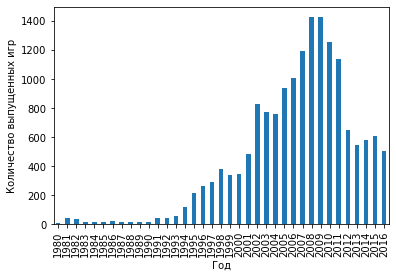

In [17]:
data.groupby('year_of_release')['name'].count().plot(kind='bar');
plt.ylabel('Количество выпущенных игр');
plt.xlabel('Год');

Как мы видим, до 1994 года вышло совсем незначительное количество игр. Всплеск gamedev'а приходится на 2005-2011 годы. <br>
Следовательно, в исследовании нам не так важно учитывать игры, вышедшие до 1994 года.

Посмотрим, как менялись продажи по платформам. Отберём 7 платформ с наибольшими суммарными продажами:

In [18]:
platforms = data.groupby('platform')['total_sales'].sum().sort_values(ascending=False).index[:7]

**Для них построим распределение суммарных продаж по годам:**

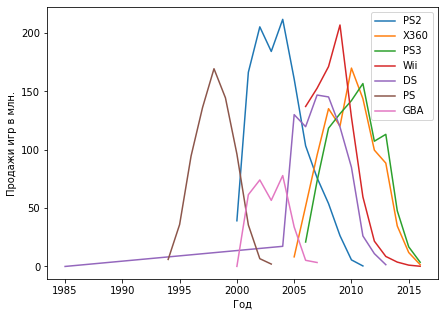

In [19]:
for plaform in platforms:
    data[data['platform']==plaform].groupby('year_of_release')['total_sales'].sum().plot(figsize=(7,5));
plt.legend(platforms);
plt.ylabel('Продажи игр в млн.');
plt.xlabel('Год');

По такому графику можно заметить, что пик популярности платформы **в среднем длится не более 5 лет**, после чего появляется новая платформа и сменяет предыдущую <br>
Теперь посмотрим на средний полный жизненный срок существования консоли:

In [20]:
platform = data.groupby('platform')['year_of_release'].agg(['min', 'max'])
print(f"Средний полный жизненный срок существования консоли: {'%.2f'%(platform['max']-platform['min']).mean()} лет")

Средний полный жизненный срок существования консоли: 7.61 лет


В качестве актуального периода для прогнозирования на 2017 год можно выбрать **данные за 2013-2016 годы**, так как эти данные всё ещё актуальны (особенно учитывая тот факт, что индустрия компьютерных игр достаточно быстро меняется)

**Посмотрим, какие плафтормы лидируют в этом актуальном периоде по продажам:**

In [21]:
actual_data = data[data['year_of_release']>=2013]

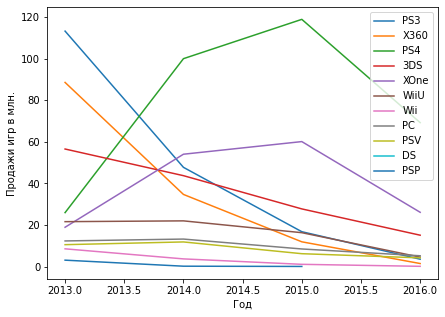

In [22]:
for plaform in actual_data['platform'].unique():
    actual_data[actual_data['platform']==plaform].groupby('year_of_release')['total_sales'].sum().plot(figsize=(7,5));
plt.legend(list(actual_data['platform'].unique()));
plt.ylabel('Продажи игр в млн.');
plt.xlabel('Год');

Как мы видим, по продажам игр сейчас лидируют платформы нового поколения (на 2016 год): это PS4 и Xbox One. Популярные платформы прошлого поколения уже почти упали в продажах по играм. К таким относятся платформы PS3, Xbox 360 и Nintendo 3ds

Теперь построим ящик с усами по глобальным продажам игр в разбивке по платформам за актуальный период 2013-2016 годов:

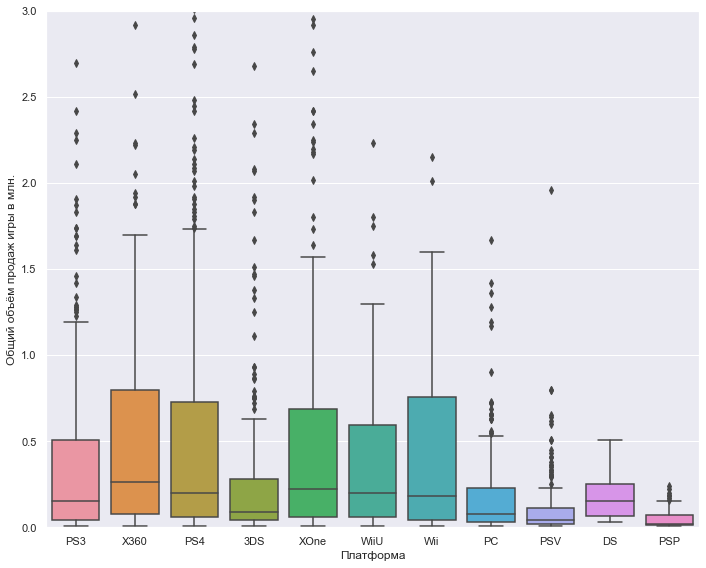

In [23]:
sns.set(rc={'figure.figsize':(11.7,9.5)})
plt.ylim(0, 3);
sns.boxplot(x=actual_data["platform"], y=actual_data['total_sales']).\
set(xlabel='Платформа', ylabel='Общий объём продаж игры в млн.');

Отсюда мы можем увидеть, какую игру можно считать популярной в зависимости от общего объёма её продаж. <br>
Так, например, для платформы PS3 популярными можно считать те игры, суммарный объём продаж которых превысил 1.25 миллиона копий, когда в среднем продаётся примерно 150 тысяч копий игры <br>
Для платформ Xbox 360 и PS4 популярными можно считать те игры, суммарный объём продаж которых превысил 1.75 миллиона копий

**Теперь посмотрим, как внутри платформы PS4 на продажу игр влияют отзывы критиков и пользователей:**

In [24]:
ps4_data = actual_data[(actual_data['platform']=='PS4')]

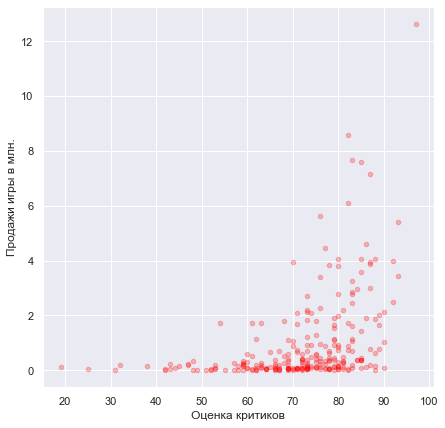

In [25]:
sns.set(rc={'figure.figsize':(7, 7)})
ps4_data.plot.scatter(x='critic_score', y="total_sales", alpha=0.25, c='red');
plt.ylabel('Продажи игры в млн.');
plt.xlabel('Оценка критиков');

In [26]:
ps4_data['critic_score'].astype(dtype='float').corr(ps4_data['total_sales'])

0.40656790206178095

Как мы видим, оценка критиков действительно влияет на объём продаж игры. Имеется небольшая линейная связь: как правило, чем выше оценка критиков, тем больше у игры продажи

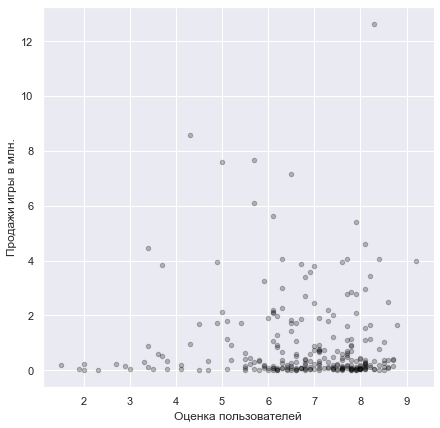

In [27]:
ps4_data.plot.scatter(x='user_score', y="total_sales", alpha=0.25, c='black');
plt.ylabel('Продажи игры в млн.');
plt.xlabel('Оценка пользователей');

In [28]:
ps4_data['user_score'].corr(ps4_data['total_sales'])

-0.031957110204556424

А вот оценка пользователей, как оказалось, почти не влияет на объёмы продаж самой игры (линейный коэффициент корреляции близок к нулю)

**Соотнесём выводы с продажами игр на других платформах:**

In [29]:
print('Платформа\t Критики\t\tПользователи \t Количество игр')
for platform in actual_data['platform'].unique():
    corr_critic = actual_data[(actual_data['platform']==platform) & (~actual_data['critic_score'].isna())]\
    ['critic_score'].astype(dtype='float').\
    corr(actual_data[(actual_data['platform']==platform) & (~actual_data['critic_score'].isna())]['total_sales'])
    corr_user = actual_data[(actual_data['platform']==platform) & (~actual_data['user_score'].isna())]['user_score'].\
    corr(actual_data[(actual_data['platform']==platform) & (~actual_data['user_score'].isna())]['total_sales'])
    print(f'{platform}:\t\t {"%.2f"%corr_critic} \t\t{"%.2f"%corr_user} \t\t {actual_data[actual_data["platform"]==platform].shape[0]}')
    

Платформа	 Критики		Пользователи 	 Количество игр
PS3:		 0.33 		0.00 		 345
X360:		 0.35 		-0.01 		 186
PS4:		 0.41 		-0.03 		 392
3DS:		 0.36 		0.24 		 303
XOne:		 0.42 		-0.07 		 247
WiiU:		 0.38 		0.42 		 115
Wii:		 nan 		0.68 		 23
PC:		 0.20 		-0.09 		 189
PSV:		 0.25 		0.00 		 358
DS:		 nan 		nan 		 8
PSP:		 nan 		-1.00 		 67


/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2683: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/opt/anaconda3/lib/python3.9/site-packages/numpy/lib/function_base.py:2542: RuntimeWarning: divide by zero encountered in true_divide
  c *= np.true_divide(1, fact)


По платформам Wii, DS и PSP даже не получилось посчитать корреляцию из-за отсутствия хотя бы двух оценок критиков.

Оказалось, что такая ситуация, как на PS4, наблюдается почти везде, за исключением некоторых платформ, где оценок критиков или пользователей было недостаточно.

Данные по платформе PS2 учитывать не стоит из-за небольшого количества вышедших игр.

**Теперь посмотрим на распределение игр по жанрам:**

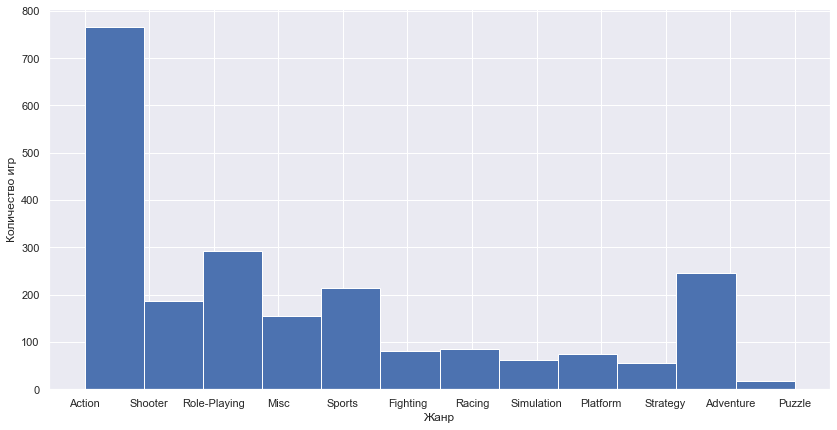

In [30]:
sns.set(rc={'figure.figsize':(14, 7)})
actual_data['genre'].hist(bins=12);
plt.ylabel('Количество игр');
plt.xlabel('Жанр');

Как мы видим, самым популярным жанром с большим отрывом от других является "Экшен"

**Посмотрим на самые прибыльные жанры:**

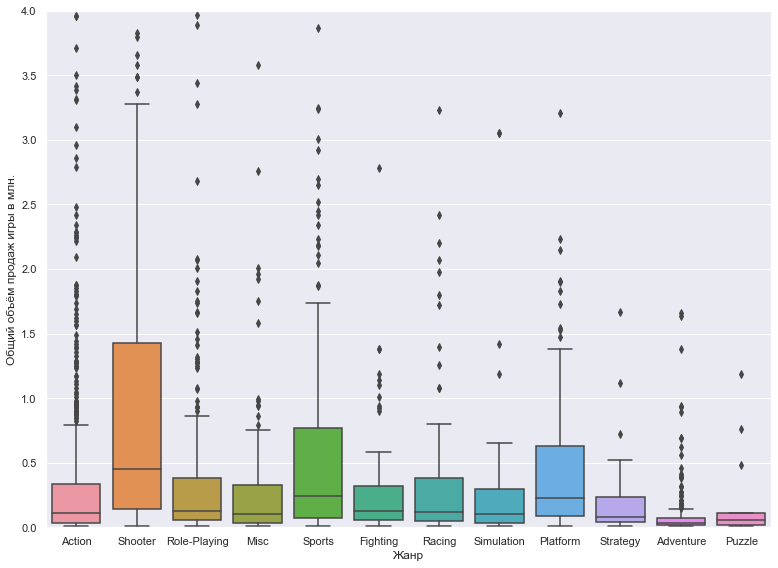

In [31]:
sns.set(rc={'figure.figsize':(13,9.5)})
plt.ylim(0, 4);
sns.boxplot(x=actual_data["genre"], y=actual_data['total_sales']).\
set(xlabel='Жанр', ylabel='Общий объём продаж игры в млн.');

Оказалось, что самые популярные жанры необязательно приносят самый большой доход в среднем <br>
Так, например, несмотря на то, что в жанре Action было выпущено наибольшее количество игр, средние продажи в этом жанре в 5 раз меньше, чем в жанре Shooter <br>
Можно выделить явных лидеров по средним продажам:
1. Shooter - 500 тысяч копий
2. Sports - 300 тысяч копий
3. Platform - 250 тысяч копий <br>

Таким образом, можно сделать вывод: **большое количество выпущенных игр в определённом жанре необязательно говорит о том, что этот жанр будет наиболее прибыльным**

### Составим портрет пользователя каждого региона

#### Регион NA
**Посмотрим на топ-5 популярных платформ:**

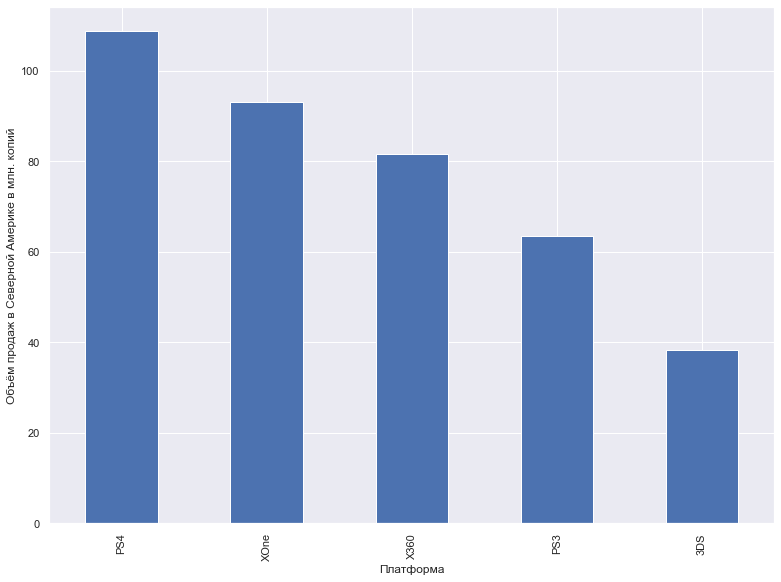

In [32]:
actual_data.groupby('platform')['na_sales'].sum().\
sort_values(ascending=False).head(5).plot.bar();
plt.ylabel('Объём продаж в Северной Америке в млн. копий');
plt.xlabel('Платформа');

В Северной Америке на период 2013-2016 годов самыми популярными платформами ещё являлись платформы прошлого поколения, то есть Xbox 360 и PS3, а весь рынок, можно сказать, разделяют между собой Xbox и PlayStation. Nintendo с платформой 3DS занимает лишь 5-ое место

**Топ-5 популярных жанров:**

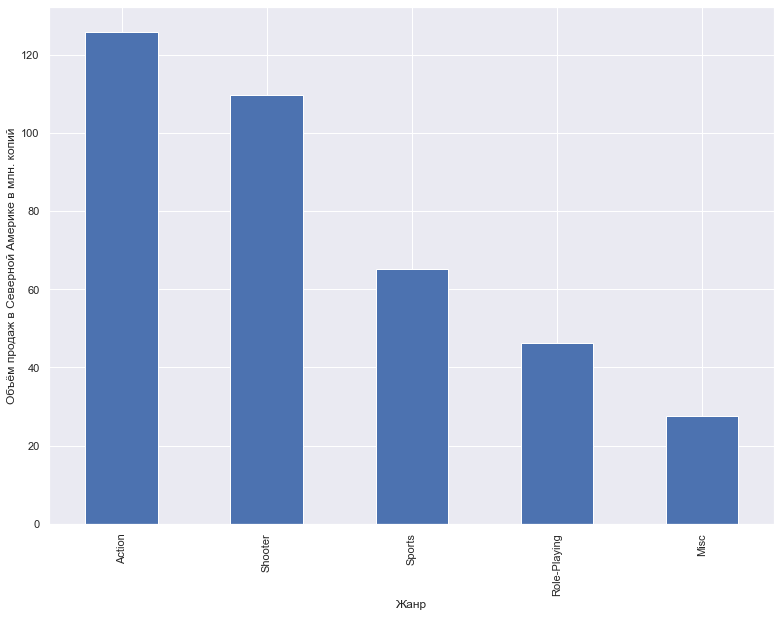

In [33]:
actual_data.groupby('genre')['na_sales'].sum().\
sort_values(ascending=False).head(5).plot.bar();
plt.ylabel('Объём продаж в Северной Америке в млн. копий');
plt.xlabel('Жанр');

В Северной Америке лидируют жанры Action и Shooter с объёмами продаж в 200 млн. копий, затем идут жанры Sports (~100 млн. копий), Role-playing и Miscellaneous (менее 100 млн. копий)

**Влияние рейтинга ESRB на продажи:**

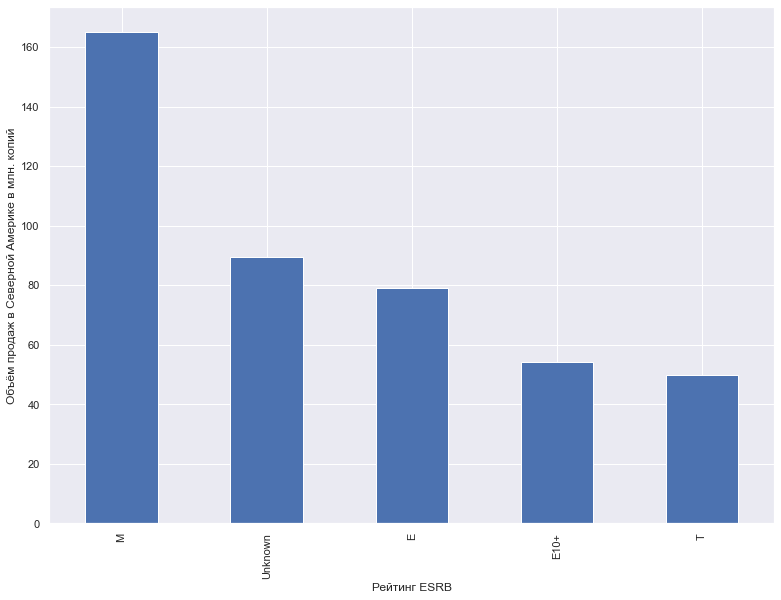

In [34]:
actual_data.groupby('rating')['na_sales'].sum().sort_values(ascending=False).plot.bar();
plt.ylabel('Объём продаж в Северной Америке в млн. копий');
plt.xlabel('Рейтинг ESRB');

Как мы видим, количество продаж в NA действительно в какой-то степени связано с рейтингом ESRB. Так, самыми продаваемыми являются игры с рейтингом M (17+). Игры с рейтингами E(6+), E10+(10+) и T(13+) и вообще без рейтинга продаются значительно меньше.

#### Регион EU
**Посмотрим на топ-5 популярных платформ:**

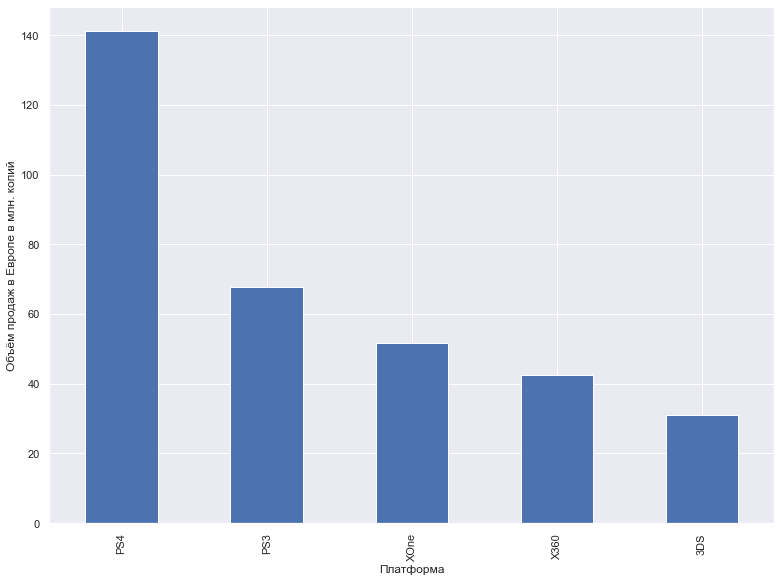

In [35]:
actual_data.groupby('platform')['eu_sales'].sum().\
sort_values(ascending=False).head(5).plot.bar();
plt.ylabel('Объём продаж в Европе в млн. копий');
plt.xlabel('Платформа');

В Европе на момент 2016 года самой популярной платформой является PlayStation (PS3 и PS4 продали суммарно 300 млн. копий), когда Xbox360 занимает лишь третье место (а Xbox One и вовсе нет в топе). Также европейские геймеры предпочитают Nintendo 3DS и PC (по ~60 млн. копий)

**Топ-5 популярных жанров:**

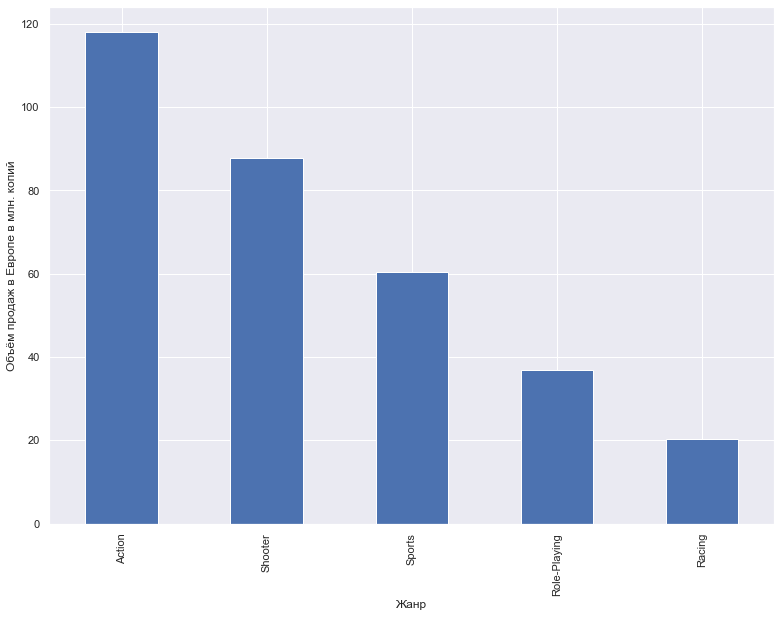

In [36]:
actual_data.groupby('genre')['eu_sales'].sum().\
sort_values(ascending=False).head(5).plot.bar();
plt.ylabel('Объём продаж в Европе в млн. копий');
plt.xlabel('Жанр');

В Европе лидирующие жанры почти не отличаются от топ-жанров Северной Америки. Единственное отличие в топ-5 заключается в том, что европейцы предпочитают гонки (5-ое место)

**Влияние рейтинга ESRB на продажи:**

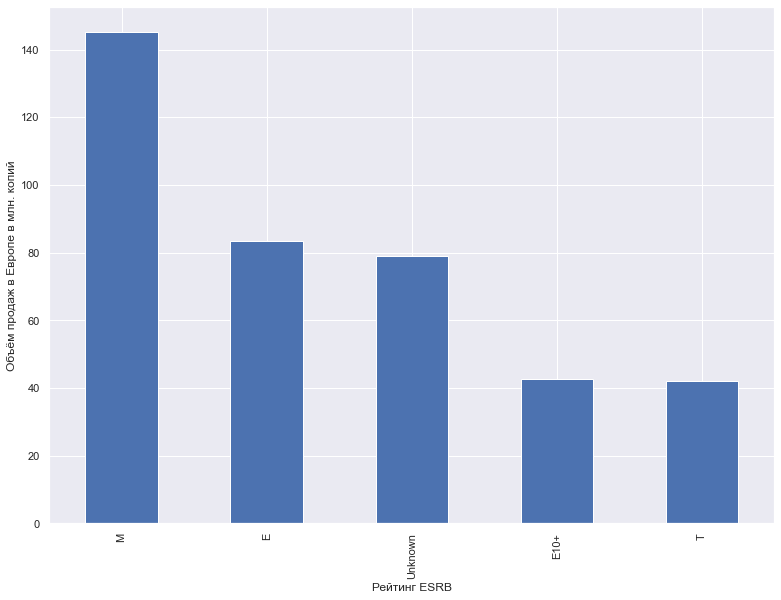

In [37]:
actual_data.groupby('rating')['eu_sales'].sum().sort_values(ascending=False).plot.bar();
plt.ylabel('Объём продаж в Европе в млн. копий');
plt.xlabel('Рейтинг ESRB');

Рейтинг ESRB влияет на продажи игр почти так же, как и в Северной Америке. Однако стоит отметить, что в Европе чуть чаще продаются игры с рейтингом E(6+)

#### Регион JP
Посмотрим на топ-5 популярных платформ:

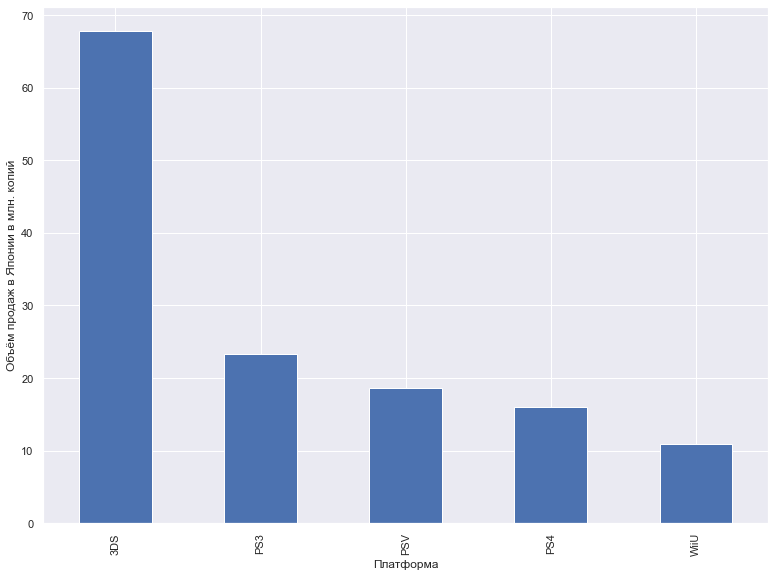

In [38]:
actual_data.groupby('platform')['jp_sales'].sum().\
sort_values(ascending=False).head(5).plot.bar();
plt.ylabel('Объём продаж в Японии в млн. копий');
plt.xlabel('Платформа');

На рынке Японии ситуация сильно отличается: абсолютным лидером рынка на 2016 год является отечественная компания Nintendo с платформой 3DS. Оставшиеся 4 позиции занимает японский производитель PlayStation.

**Топ-5 популярных жанров:**

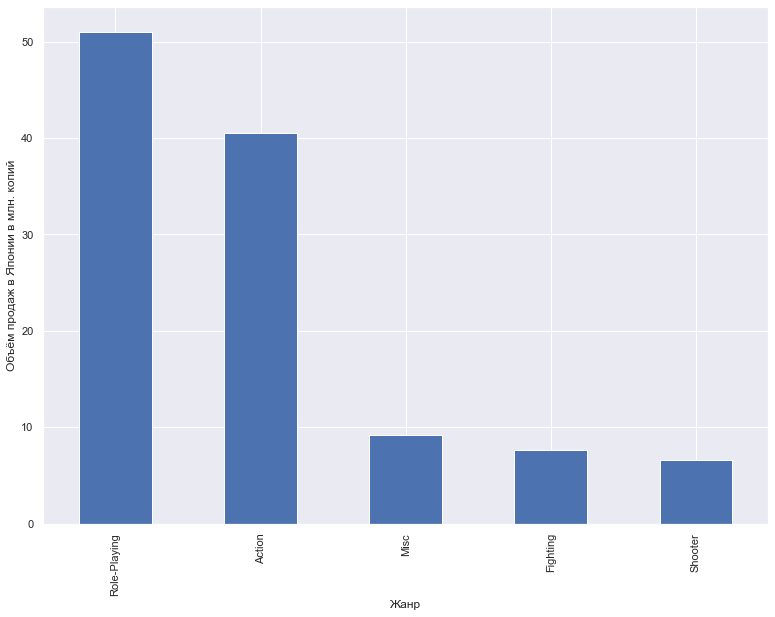

In [39]:
actual_data.groupby('genre')['jp_sales'].sum().\
sort_values(ascending=False).head(5).plot.bar();
plt.ylabel('Объём продаж в Японии в млн. копий');
plt.xlabel('Жанр');

Ситуация с жанрами тоже очень сильно изменилась: геймеры Японии предпочитают жанру "Экшен" ролевые игры (80 млн. проданных копий), а на оставшихся трёх местах находятся жанры Misc, Fighting и Platform

**Влияние рейтинга ESRB на продажи:**

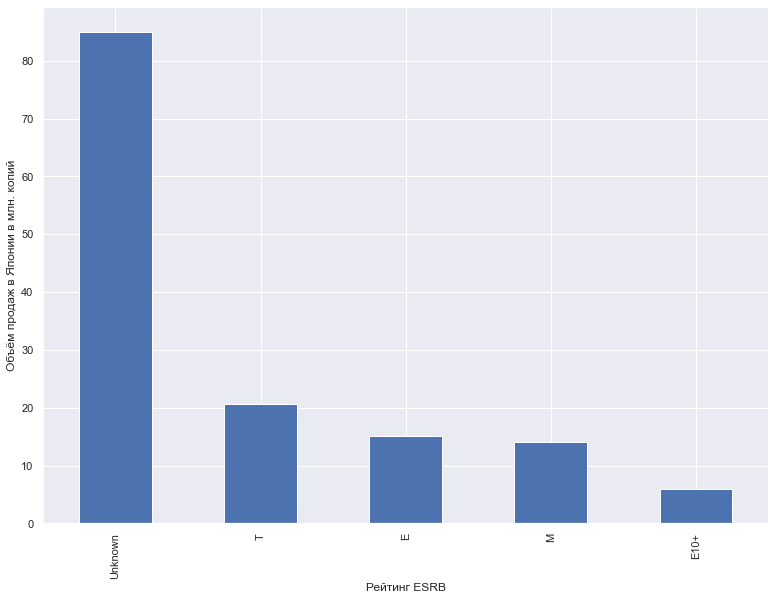

In [40]:
actual_data.groupby('rating')['jp_sales'].sum().sort_values(ascending=False).plot.bar();
plt.ylabel('Объём продаж в Японии в млн. копий');
plt.xlabel('Рейтинг ESRB');

Оказалось, что в Японии любят игры без насилия и грубой жестокости: об этом говорят высокие продажи игр с рейтингом E(6+) и T(13+), на которые приходится примерно 70 млн. проданных копий <br>
А ещё больше предпочитают игры, которым вообще не присвоили рейтинг ESRB. Таких игр абсолютное подавляющее большинство.

### Проверяем гипотезы

Первая гипотеза звучит так: **"Средние пользовательские рейтинги платформ Xbox One и PC одинаковые"** <br>
**Нулевая гипотеза**: Средний пользовательский рейтинг платформы Xbox One равен среднему пользовательскому рейтингу платформы PC <br>
**Альтернативная гипотеза**: Средний пользовательский рейтинг платформы Xbox One не равен среднему пользовательскому рейтингу платформы PC

In [41]:
xbox = actual_data.query('platform=="XOne"')['user_score']
pc = actual_data.query('platform=="PC"')['user_score']

Мы проверяем гипотезу о равенстве средних двух независимых генеральных совокупностей, поэтому используем ttest_ind():

In [42]:
results = st.ttest_ind(xbox, pc, equal_var=True)
alpha = 0.05

print(f'P-Value = {results.pvalue}')
if results.pvalue>alpha:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

P-Value = nan
Отвергаем нулевую гипотезу


Так как размеры генеральных совокупностей небольшие, мы могли бы просто сравнить их средние:

In [43]:
print(f'Средний пользовательский рейтинг на Xbox One: {"%.2f"%xbox.mean()}')
print(f'Средний пользовательский рейтинг на PC: {"%.2f"%pc.mean()}')

Средний пользовательский рейтинг на Xbox One: 6.52
Средний пользовательский рейтинг на PC: 6.27


Отсюда мы так же можем **подтвердить**, что **средние пользовательские рейтинги платформ Xbox One и PC почти не отличаются, то есть одинаковы**

Вторая гипотеза звучит так: **"Средние пользовательские рейтинги жанров Action и Sports разные"** <br>
**Нулевая гипотеза**: Средний пользовательский рейтинг жанра Action равен среднему пользовательскому рейтингу жанра Sports <br>
**Альтернативная гипотеза**: Средний пользовательский рейтинг жанра Action не равен среднему пользовательскому рейтингу жанра Sports

In [44]:
action = actual_data.query('genre=="Action"')['user_score']
sports = actual_data[(actual_data['genre']=='Sports') & (~actual_data['user_score'].isna())]['user_score']

Мы проверяем гипотезу о равенстве средних двух генеральных совокупностей, поэтому используем ttest_ind() с параметром equal_var=False, так как дисперсии двух генеральных совокупностей в данном случае могут значительно отличаться:

In [45]:
results = st.ttest_ind(action, sports, equal_var=False)
alpha = 0.05

print(f'P-Value = {results.pvalue}')
if results.pvalue>alpha:
    print('Не получилось отвергнуть нулевую гипотезу')
else:
    print('Отвергаем нулевую гипотезу')

P-Value = nan
Отвергаем нулевую гипотезу


Также для проверки мы можем просто посчитать средние двух генеральных совокупностей:

In [46]:
print(f'Средний пользовательский рейтинг жанра Action: {"%.2f"%action.mean()}')
print(f'Средний пользовательский рейтинг жанра Sports: {"%.2f"%sports.mean()}')

Средний пользовательский рейтинг жанра Action: 6.84
Средний пользовательский рейтинг жанра Sports: 5.24


Отсюда мы также можем **подтвердить**, что **средние пользовательские рейтинги жанров Action и Sports разные**

### Общий вывод

Для того, чтобы выявить факторы, определяющие успех игры в 2017 году, мы предобработали данные о продажах игр и поняли, что следует рассматривать данные за последние 4 года (2013-2016 гг.), чтобы учесть все необходимые тенденции <br>
В результате исследования было определено, что:
- сейчас (т.е. в 2016) старые платформы Xbox 360, PS3 и 3DS уступают место новым, активно набирающим популярность платформам следующего поколения: PS4 и Xbox One. Именно эти платформы лидируют по общим продажам игр.
- Популярными играми на платформах PS4 и Xbox One можно считать те игры, объём продаж копий которых превысил 1.75 миллионов по всему миру
- Высокая оценка критиков положительно влияет на продажи игры почти на всех платформах (исключения стоит подробнее посмотреть в соответствующем разделе). Оценка пользователей почти не влияет на продажи игры (возможно, за исключением платформы WiiU)
- Самыми популярными и хорошо продаваемыми жанрами являются шутеры, спортивные симуляторы и платформеры
- Большое количество выпущенных игр в определённом жанре не всегда говорит о том, что этот жанр будет наиболее прибыльным
- На разных рынках (Северная Америка, Европа, Япония) есть характерные особенности, которые нужно обязательно учитывать при планировании рекламных компаний (см. подробнее в п.5)
- Предположительно, пользовательский рейтинг игры почти не отличается на разных платформах

Данные статистические выводы можно использовать, чтобы планировать рекламную компанию и сделать ставку на потенциально популярный продукт нашего магазина "Стримчик".